# ML Pipeline de Operaciones en Earthquake para Predecir Destruction Level con GradientBoostingClassifier

## Objetivos

### Predecir Destruction Level (y numérica) a partir de X con features numéricas.

Agrupar múltiples operaciones en un mismo objeto:

* Borrar columnas, imputar valores faltantes
* Preprocessing: Umbrales y función estadística para determinar niveles de bajo a muy alto a imputar en columna categórica Earthquake Type.
* OneHotEncoder para pasar de columna categórica Earthquake Type a numérica Destruction Level.
* Pipeline:
    + Imputar most_frequent a nulos con SimpleImputer
    + Escalar características numéricas
    + GradientBoostingClassifier
* Modelado para predecir Destruction Level

## Importar librerías

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split X train y test
from sklearn.model_selection import train_test_split

# Modelos para validación cruzada con cross_val_score y cross_validate
from sklearn.ensemble import GradientBoostingClassifier # Elegido
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos para validar por regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Validación de modelos:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Calificación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

# Para imputación categórica a numérica y predicción de columna numérica Destruction Level en Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

# Convertir columnas categóricas (Disaster Subtype, Origin, Associated Disaster) a numéricas para predecir Destruction Level Dis o Mag Value
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Pipeline
from sklearn.pipeline import Pipeline
import joblib # guardar pipeline

## Cargar datos

In [121]:
df = pd.read_csv('../../../Data/03Limpio/03desastreslimpio.csv')
df.head(10)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,...,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
0,1900-9002-CPV,1900,9002,Climatological,Drought,Drought,Cabo Verde,CPV,Western Africa,Africa,...,NaN,1900,0,0,1900,0,0,11000,0,0
1,1900-9001-IND,1900,9001,Climatological,Drought,Drought,India,IND,Southern Asia,Asia,...,NaN,1900,0,0,1900,0,0,1250000,0,0
2,1902-0012-GTM,1902,12,Geophysical,Earthquake,Ground movement,Guatemala,GTM,Central America,Americas,...,-91,1902,4,18,1902,4,18,2000,0,843726
3,1902-0003-GTM,1902,3,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,...,NaN,1902,4,8,1902,4,8,1000,0,0
4,1902-0010-GTM,1902,10,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,...,NaN,1902,10,24,1902,10,24,6000,0,0
5,1903-0006-CAN,1903,6,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,...,NaN,1903,4,29,1903,4,29,76,23,0
6,1903-0012-COM,1903,12,Geophysical,Volcanic activity,Ash fall,Comoros (the),COM,Eastern Africa,Africa,...,NaN,1903,0,0,1903,0,0,17,0,0
7,1904-0003-BGD,1904,3,Meteorological,Storm,Tropical cyclone,Bangladesh,BGD,Southern Asia,Asia,...,NaN,1904,11,0,1904,11,0,0,0,0
8,1905-0005-CAN,1905,5,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,...,NaN,1905,8,13,1905,8,13,18,18,0
9,1905-0003-IND,1905,3,Geophysical,Earthquake,Ground movement,India,IND,Southern Asia,Asia,...,76.16,1905,4,4,1905,4,4,20000,0,812477


## Comprobación Básica df

In [122]:
df.shape

(16636, 26)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16636 entries, 0 to 16635
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dis No             16636 non-null  object
 1   Year               16636 non-null  int64 
 2   Seq                16636 non-null  int64 
 3   Disaster Subgroup  16636 non-null  object
 4   Disaster Type      16636 non-null  object
 5   Disaster Subtype   13313 non-null  object
 6   Country            16636 non-null  object
 7   ISO                16636 non-null  object
 8   Region             16636 non-null  object
 9   Continent          16636 non-null  object
 10  Location           14825 non-null  object
 11  Origin             4085 non-null   object
 12  Associated Dis     3593 non-null   object
 13  Dis Mag Value      16636 non-null  int64 
 14  Dis Mag Scale      15416 non-null  object
 15  Latitude           2775 non-null   object
 16  Longitude          2775 non-null   objec

In [124]:
df.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj'],
      dtype='object')

In [125]:
print(df.isnull().sum())
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64
Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location       

# Preparación de dataset

### Filtro Earthquake

In [126]:
# Filtro principal para Earthquake
df_earthquake = df[df['Disaster Type'] == 'Earthquake']

### Limpieza

#### Borrar columnas

In [127]:
df_earthquake.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'ISO'], inplace=True)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_17656\4288529280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_earthquake.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'ISO'], inplace=True)


In [128]:
df_earthquake.head(2)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,...,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
2,Earthquake,Ground movement,Guatemala,Central America,Americas,"Quezaltenango, San Marcos",NaN,Tsunami/Tidal wave,8,Richter,...,-91,1902,4,18,1902,4,18,2000,0,843726
9,Earthquake,Ground movement,India,Southern Asia,Asia,Kangra,NaN,NaN,8,Richter,...,76.16,1905,4,4,1905,4,4,20000,0,812477


### Valores faltantes

In [129]:
# # Rellenar valores faltantes y nulls con 0, después, borrar filas con valores faltantes
# df_earthquake = df_earthquake.copy()
# df_earthquake.fillna(0, inplace=True)

## Preprocessing

## Preprocessing 1: crear columna categórica Earthquake Type y codificar columna numérica Destruction Level con OneHotEncoder para predecir y

### Filtro para excluir filas con valores 0 en 'Dis Mag Value', 'Total Deaths', 'Total Affected' y 'Total Damages Adj'

In [130]:
# df_earthquake = df[(df['Dis Mag Value'] > 0) & 
#                  (df['Total Deaths'] > 0) & 
#                  (df['Total Affected'] > 0) & 
#                  (df['Total Damages Adj'] > 0)]

In [131]:
df_earthquake['Dis Mag Value'].min()

0

In [132]:
df_earthquake.shape

(1597, 21)

### Condiciones estadísticas para determinar umbrales de clasificación para Tipo de Inundación y su Nivel de Destrucción

In [133]:
min_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].min()
max_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].max()
std_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].std()
mean_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].mean()
median_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].median()

min_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].min()
max_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].max()
std_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].std()
mean_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].mean()
median_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].median()

min_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].min()
max_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].max()
std_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].std()
mean_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].mean()
median_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].median()

min_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].min()
max_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].max()
std_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].std()
mean_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].mean()
median_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].median()

In [134]:
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].min())
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].max())
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].std())
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].mean())
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].median())

print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].min())
print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].max())
print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].std())
print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].mean())
print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].median())

print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].min())
print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].max())
print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].std())
print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].mean())
print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].median())

print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].min())
print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].max())
print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].std())
print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].mean())
print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].median())

1
10
1.0176460696536391
6.3958885941644565
6.0
1
242000
14158.235839663068
2002.136894824708
18.0
1
45976596
1475999.0555363484
167772.02803030302
4112.0
2
273218373
15320213.852360478
2602513.2398703406
114655.0


### Tipos de umbrales de destrucción de terremoto

Los umbrales se definen con base en la información de Wikipedia sobre Escala de Richter: https://es.wikipedia.org/wiki/Escala_sismol%C3%B3gica_de_Richter

* Type 1 Threshold (Micro):

Magnitude (Dis Mag Value) < 2.0

* Type 2 Threshold (Minor):

Magnitude (Dis Mag Value) >= 2.0 and < 4.0
Total Deaths < 100
Total Affected < 10,000
Total Damages Adj < 1,000,000

* Type 3 Threshold (Light):

Magnitude (Dis Mag Value) >= 4.0 and < 6.0
Total Deaths < 500
Total Affected < 100,000
Total Damages Adj < 10,000,000

* Type 4 Threshold (Moderate):

Magnitude (Dis Mag Value) >= 6.0 and < 7.0
Total Deaths < 1,000
Total Affected < 500,000
Total Damages Adj < 100,000,000

* Type 5 Threshold (Strong):

Magnitude (Dis Mag Value) >= 7.0 and < 8.0
Total Deaths < 5,000
Total Affected < 1,000,000
Total Damages Adj < 1,000,000,000

* Type 6 Threshold (Major):

Magnitude (Dis Mag Value) >= 8.0 and < 9.0
Total Deaths < 10,000
Total Affected < 5,000,000
Total Damages Adj < 10,000,000,000

* Type 7 Threshold (Epic or Catastrophic):

Magnitude (Dis Mag Value) >= 9.0
Total Deaths < 50,000
Total Affected < 10,000,000
Total Damages Adj < 100,000,000,000

* Type 8 Threshold (Legendary or Apocalyptic):

Magnitude (Dis Mag Value) >= 10.0
Total Deaths >= 50,000
Total Affected >= 10,000,000
Total Damages Adj >= 100,000,000,000

Los umbrales están definidos para ser inclusivos en el límite inferior (>=) y exclusivos en el límite superior (<). Esto significa que un evento sísmico con una magnitud de exactamente 2.0 será considerado como 'Menor' en lugar de 'Micro', y así sucesivamente.

In [135]:
# Thresholds for Earthquake Types based on Dis Mag Value
type1_threshold = 2.0
type2_threshold = 4.0
type3_threshold = 6.0
type4_threshold = 7.0
type5_threshold = 8.0
type6_threshold = 9.0
type7_threshold = 10.0

# Thresholds for Earthquake Types based on Total Deaths, Total Affected, and Total Damages Adj
type2_max_deaths = 100
type2_max_affected = 10000
type2_max_damages = 1000000

type3_max_deaths = 500
type3_max_affected = 100000
type3_max_damages = 10000000

type4_max_deaths = 1000
type4_max_affected = 500000
type4_max_damages = 100000000

type5_max_deaths = 5000
type5_max_affected = 1000000
type5_max_damages = 1000000000

type6_max_deaths = 10000
type6_max_affected = 5000000
type6_max_damages = 10000000000

type7_max_deaths = 50000
type7_max_affected = 10000000
type7_max_damages = 100000000000

# Nota: Para tipo 'Legendary or Apocalyptic' type (magnitude >= 10.0), no se definen umbrales específicos para la columna de impacto.


### Función para crear columna categórica de nivel de impacto: Earthquake Type

In [136]:
def assign_earthquake_type(row):
    magnitude = row['Dis Mag Value']
    deaths = row['Total Deaths']
    affected = row['Total Affected']
    damages = row['Total Damages Adj']

    if magnitude < 2.0:
        return 'Micro'
    elif 2.0 <= magnitude < 4.0 and deaths < 100 and affected < 10000 and damages < 1000000:
        return 'Minor'
    elif 4.0 <= magnitude < 6.0 and deaths < 500 and affected < 100000 and damages < 10000000:
        return 'Light'
    elif 6.0 <= magnitude < 7.0 and deaths < 1000 and affected < 500000 and damages < 100000000:
        return 'Moderate'
    elif 7.0 <= magnitude < 8.0 and deaths < 5000 and affected < 1000000 and damages < 1000000000:
        return 'Strong'
    elif 8.0 <= magnitude < 9.0 and deaths < 10000 and affected < 5000000 and damages < 10000000000:
        return 'Major'
    elif 9.0 <= magnitude and deaths < 50000 and affected < 10000000 and damages < 100000000000:
        return 'Epic or Catastrophic'
    else:
        return 'Legendary or Apocalyptic'


In [137]:
df_earthquake['Earthquake Type'] = df_earthquake.apply(assign_earthquake_type, axis=1)
df_earthquake.head(20)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_17656\1170780518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_earthquake['Earthquake Type'] = df_earthquake.apply(assign_earthquake_type, axis=1)


,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,...,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Earthquake Type
2,Earthquake,Ground movement,Guatemala,Central America,Americas,"Quezaltenango, San Marcos",NaN,Tsunami/Tidal wave,8,Richter,...,1902,4,18,1902,4,18,2000,0,843726,Major
9,Earthquake,Ground movement,India,Southern Asia,Asia,Kangra,NaN,NaN,8,Richter,...,1905,4,4,1905,4,4,20000,0,812477,Legendary or Apocalyptic
10,Earthquake,Ground movement,Chile,South America,Americas,Valparaiso,NaN,Tsunami/Tidal wave,8,Richter,...,1906,8,16,1906,8,16,20000,0,3249907,Legendary or Apocalyptic
11,Earthquake,Ground movement,Colombia,South America,Americas,Tumako,NaN,Tsunami/Tidal wave,9,Richter,...,1906,1,31,1906,1,31,400,0,0,Epic or Catastrophic
15,Earthquake,Ground movement,China,Eastern Asia,Asia,Tien Shan,NaN,NaN,7,Richter,...,1907,10,21,1907,10,21,12000,0,0,Legendary or Apocalyptic
21,Earthquake,Ground movement,France,Western Europe,Europe,"Lambesc, Saint-Cannat, Rognes, Vernegues, Char...",NaN,NaN,6,Richter,...,1909,6,11,1909,6,11,46,0,0,Moderate
28,Earthquake,Ground movement,Costa Rica,Central America,Americas,Cartago,NaN,NaN,0,Richter,...,1910,4,13,1910,4,13,1750,0,0,Micro
29,Earthquake,Ground movement,Algeria,Northern Africa,Africa,"Kabylie, Masqueray",NaN,NaN,6,Richter,...,1910,6,24,1910,6,24,12,0,0,Moderate
37,Earthquake,Ground movement,Indonesia,South-Eastern Asia,Asia,"Kepahyang, Bengkulu (Sumatera)",NaN,Tsunami/Tidal wave,8,Richter,...,1914,6,26,1914,6,26,20,20,0,Major
42,Earthquake,Ground movement,China,Eastern Asia,Asia,Yunnan province,NaN,NaN,7,Richter,...,1917,7,31,1917,7,31,1800,0,0,Strong


### Codificación categórica a numérica

#### Convertir Earthquake Type a Destruction Level numérica con OneHotEncoder

In [138]:
# Crear instancia de OneHotEncoder
encoder = OneHotEncoder()

# Ajustar y transformar la columna 'Earthquake Type'
earthquake_type_encoded = encoder.fit_transform(df_earthquake[['Earthquake Type']]).toarray()

# Obtener valores únicos en columna 'Earthquake Type'
unique_earthquake_types = df_earthquake['Earthquake Type'].unique()

# Definir un diccionario de mapeo para las categorías en 'Earthquake Type' a valores numéricos
destruction_mapping = {
    'Micro': 1,
    'Minor': 2,
    'Light': 3,
    'Moderate': 4,
    'Strong': 5,
    'Major': 6,
    'Great': 7,
    'Legendary': 8,
    'Apocalyptic': 9
}

# Crear una nueva columna 'Destruction Level' mapeando las categorías 'Earthquake Type' a valores numéricos
df_earthquake['Destruction Level'] = df_earthquake['Earthquake Type'].map(destruction_mapping)

# Aplicar one-hot encoding a columna 'Earthquake Type'
destruction_encoded = pd.get_dummies(df_earthquake['Destruction Level'], prefix='Destruction')

# Concatenar el DataFrame codificado con el original
df_earthquake_encoded = pd.concat([df_earthquake, destruction_encoded], axis=1)

# DataFrame actualizado
print(df_earthquake_encoded.head())


   Disaster Type Disaster Subtype    Country           Region Continent  \
2     Earthquake  Ground movement  Guatemala  Central America  Americas   
9     Earthquake  Ground movement      India    Southern Asia      Asia   
10    Earthquake  Ground movement      Chile    South America  Americas   
11    Earthquake  Ground movement   Colombia    South America  Americas   
15    Earthquake  Ground movement      China     Eastern Asia      Asia   

                     Location Origin      Associated Dis  Dis Mag Value  \
2   Quezaltenango, San Marcos    NaN  Tsunami/Tidal wave              8   
9                      Kangra    NaN                 NaN              8   
10                 Valparaiso    NaN  Tsunami/Tidal wave              8   
11                     Tumako    NaN  Tsunami/Tidal wave              9   
15                  Tien Shan    NaN                 NaN              7   

   Dis Mag Scale  ... Total Affected Total Damages Adj  \
2        Richter  ...              0    

C:\Users\AleEng\AppData\Local\Temp\ipykernel_17656\2280652006.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_earthquake['Destruction Level'] = df_earthquake['Earthquake Type'].map(destruction_mapping)


#### Revisión df_earthquake_encoded

In [139]:
df_earthquake_encoded.shape

(1597, 29)

In [140]:
len(df_earthquake_encoded)

1597

In [141]:
df_earthquake_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1597 entries, 2 to 16617
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Disaster Type      1597 non-null   object 
 1   Disaster Subtype   1597 non-null   object 
 2   Country            1597 non-null   object 
 3   Region             1597 non-null   object 
 4   Continent          1597 non-null   object 
 5   Location           1557 non-null   object 
 6   Origin             21 non-null     object 
 7   Associated Dis     342 non-null    object 
 8   Dis Mag Value      1597 non-null   int64  
 9   Dis Mag Scale      1597 non-null   object 
 10  Latitude           1547 non-null   object 
 11  Longitude          1547 non-null   object 
 12  Start Year         1597 non-null   int64  
 13  Start Month        1597 non-null   int64  
 14  Start Day          1597 non-null   int64  
 15  End Year           1597 non-null   int64  
 16  End Month          1597

In [142]:
df_earthquake.columns

Index(['Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Continent',
       'Location', 'Origin', 'Associated Dis', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Start Year', 'Start Month',
       'Start Day', 'End Year', 'End Month', 'End Day', 'Total Deaths',
       'Total Affected', 'Total Damages Adj', 'Earthquake Type',
       'Destruction Level'],
      dtype='object')

In [143]:
df_earthquake['Destruction Level']

2        6.0
9        NaN
10       NaN
11       NaN
15       NaN
        ... 
16610    4.0
16611    3.0
16614    3.0
16616    4.0
16617    3.0
Name: Destruction Level, Length: 1597, dtype: float64

In [144]:
df_earthquake['Destruction Level'].isnull().sum()

126

#### Imputación de nulos en columna salida (y) Destruction Level con Simple Imputer

In [145]:
# Imputar nulos en la columna de salida (y) que es Destruction Level
df_earthquake['Destruction Level'] = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_earthquake[['Destruction Level']])
df_earthquake['Destruction Level']
# borrar en lugar de imputar
# df = df.dropna('Earthquake Type')

C:\Users\AleEng\AppData\Local\Temp\ipykernel_17656\3270610574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_earthquake['Destruction Level'] = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_earthquake[['Destruction Level']])


2        6.000000
9        4.154317
10       4.154317
11       4.154317
15       4.154317
           ...   
16610    4.000000
16611    3.000000
16614    3.000000
16616    4.000000
16617    3.000000
Name: Destruction Level, Length: 1597, dtype: float64

In [146]:
df_earthquake['Earthquake Type'].isna().sum()
df_earthquake['Earthquake Type'].unique()
len(df_earthquake['Earthquake Type'])

1597

### EDA Visualizaciones de 'Destruction Level' o Nivel de Destrucción

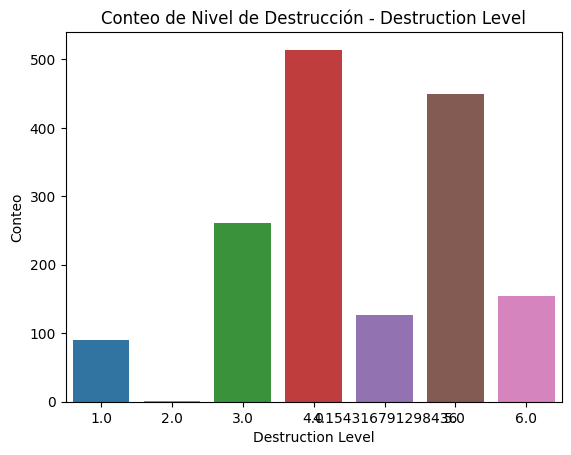

In [147]:
sns.countplot(data=df_earthquake, x='Destruction Level')
plt.title('Conteo de Nivel de Destrucción - Destruction Level')
plt.xlabel('Destruction Level')
plt.ylabel('Conteo')
plt.show()

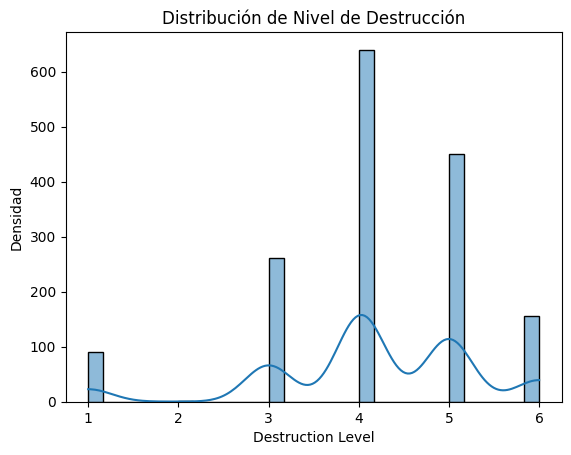

In [148]:
sns.histplot(data=df_earthquake, x='Destruction Level', kde=True)
plt.title(f'Distribución de Nivel de Destrucción')
plt.xlabel('Destruction Level')
plt.ylabel('Densidad')
plt.show()

Con el filtro > 0 cambia la densidad por nivel de destrucción, siendo 2 la más alta, seguida de 1 y 4.

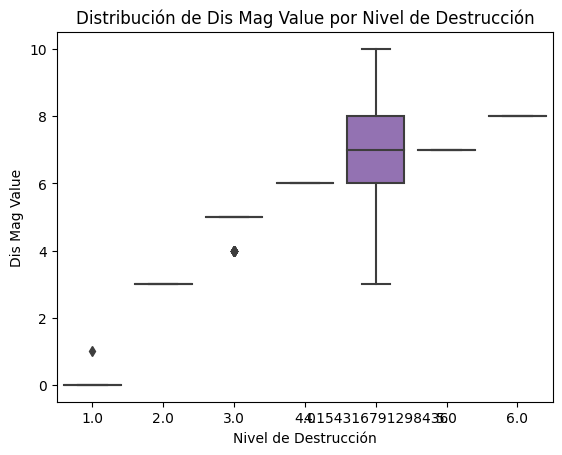

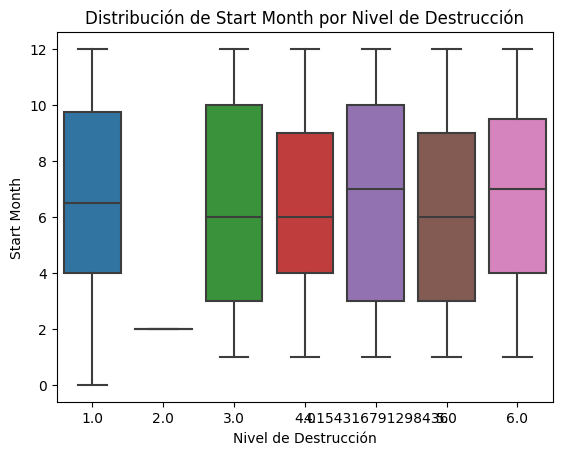

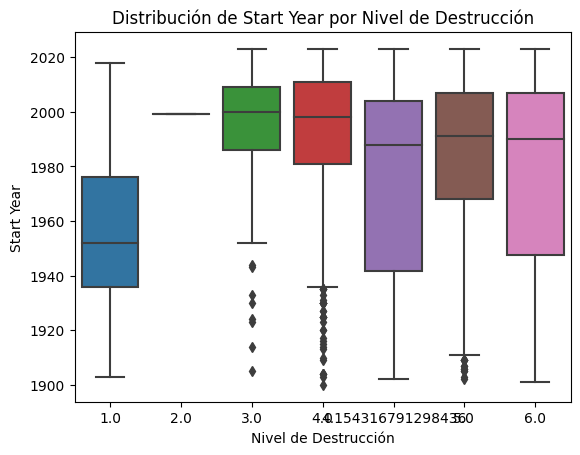

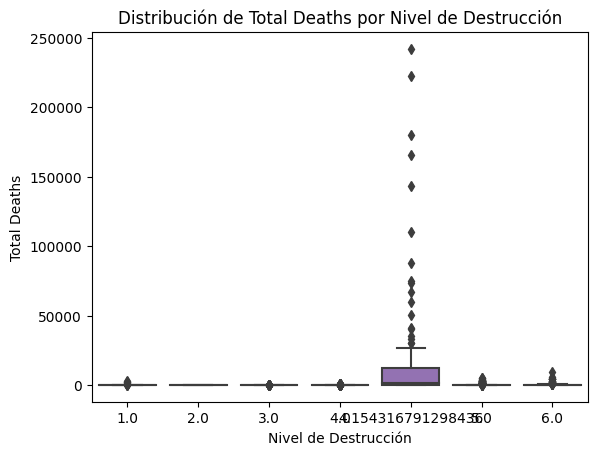

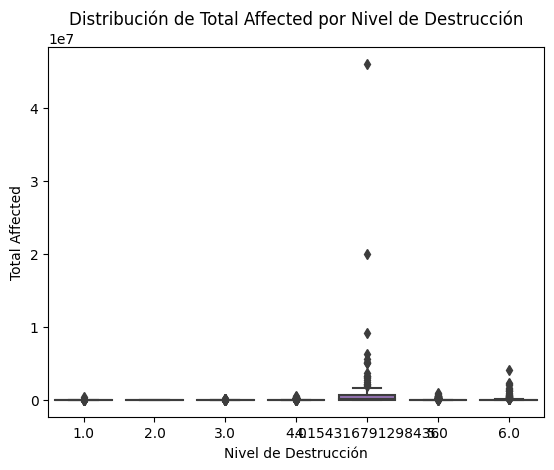

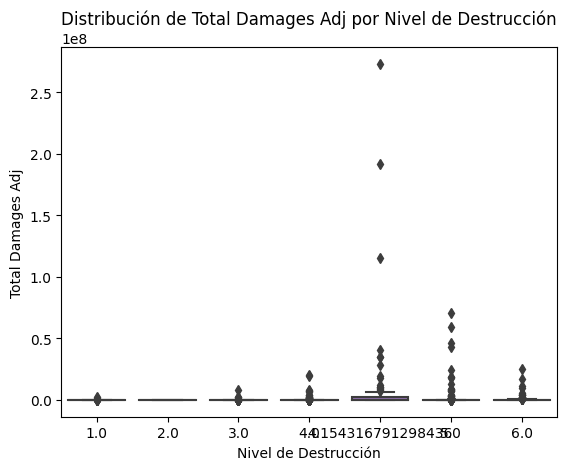

In [149]:
num_cols = ['Dis Mag Value', 'Start Month', 'Start Year', 'Total Deaths', 'Total Affected', 'Total Damages Adj']
for col in num_cols:
    sns.boxplot(data=df_earthquake, x='Destruction Level', y=col)
    plt.title(f'Distribución de {col} por Nivel de Destrucción')
    plt.xlabel('Nivel de Destrucción')
    plt.ylabel(col)
    plt.show()

In [150]:
# sns.pairplot(df_earthquake)
# Demasiado tiempo para procesar

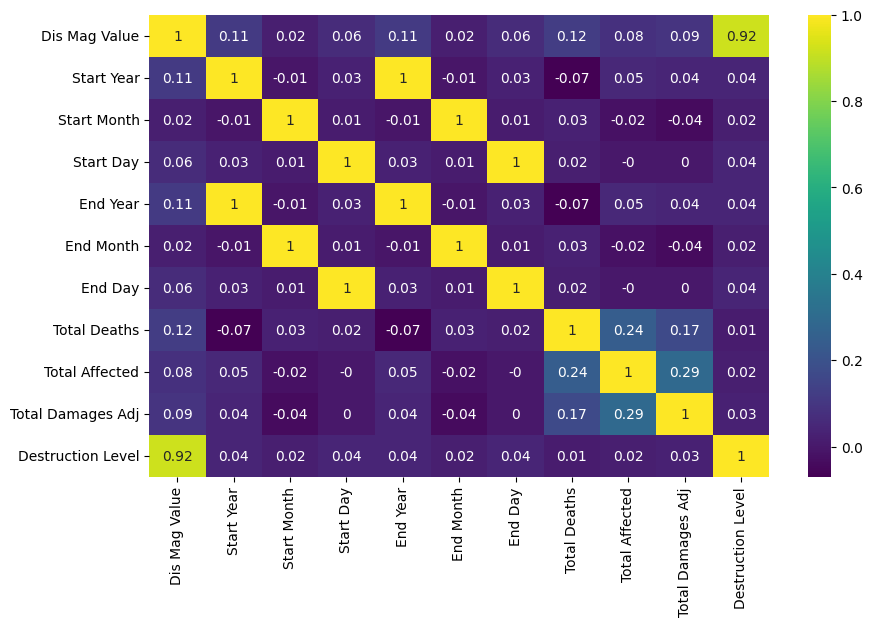

In [151]:
plt.figure(figsize=(10, 6))
df_corr = df_earthquake.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

<Axes: xlabel='Dis Mag Value', ylabel='Destruction Level'>

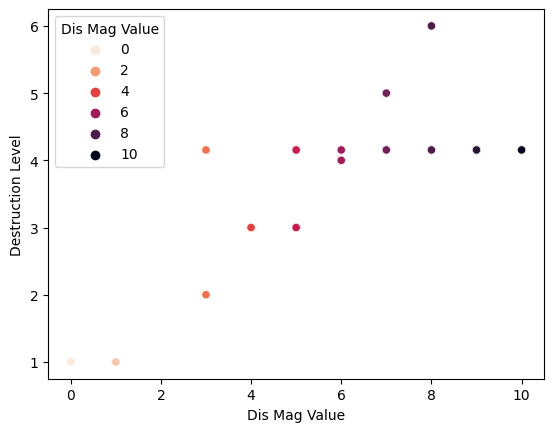

In [152]:
sns.scatterplot(data=df_earthquake, x='Dis Mag Value', y='Destruction Level', hue='Dis Mag Value', palette='rocket_r')

<Axes: xlabel='Start Month', ylabel='Destruction Level'>

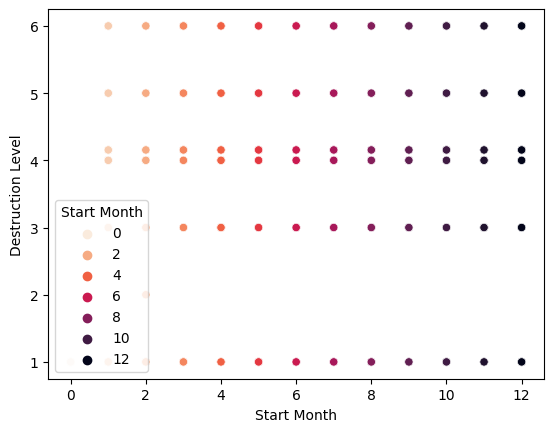

In [153]:
sns.scatterplot(data=df_earthquake, x='Start Month', y='Destruction Level', hue='Start Month', palette='rocket_r')

<Axes: xlabel='Start Year', ylabel='Destruction Level'>

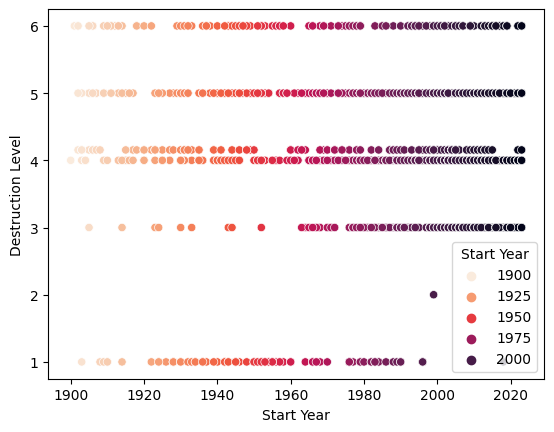

In [154]:
sns.scatterplot(data=df_earthquake, x='Start Year', y='Destruction Level', hue='Start Year', palette='rocket_r')

<Axes: xlabel='Total Deaths', ylabel='Destruction Level'>

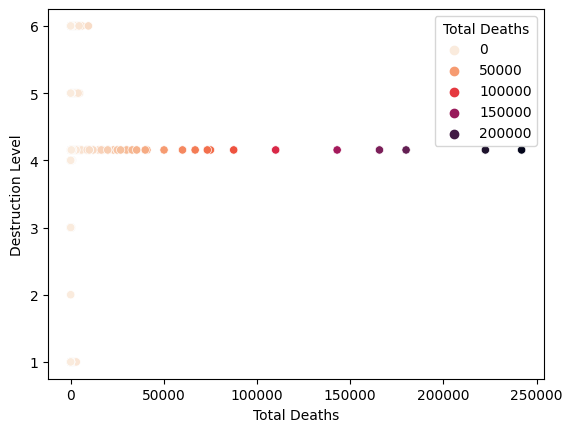

In [155]:
sns.scatterplot(data=df_earthquake, x='Total Deaths', y='Destruction Level', hue='Total Deaths', palette='rocket_r')

<Axes: xlabel='Total Affected', ylabel='Destruction Level'>

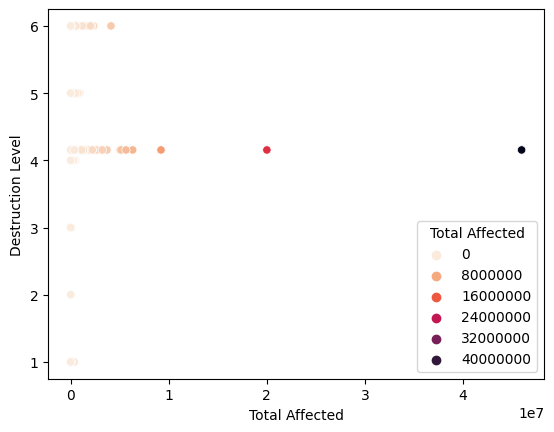

In [156]:
sns.scatterplot(data=df_earthquake, x='Total Affected', y='Destruction Level', hue='Total Affected', palette='rocket_r')

<Axes: xlabel='Total Damages Adj', ylabel='Destruction Level'>

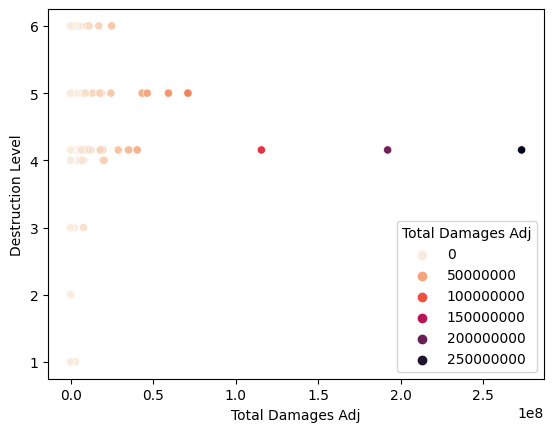

In [157]:
sns.scatterplot(data=df_earthquake, x='Total Damages Adj', y='Destruction Level', hue='Total Damages Adj', palette='rocket_r')

* La primera visualización muestra la relación entre 'Dis Mag Value' y 'Destruction Level'. Sugiere que existe una fuerte correlación entre estas dos variables, ya que el 'Nivel de destrucción' tiende a aumentar con un 'Valor de Magnitud de Desastre' más alto.
* La segunda visualización muestra la relación entre el 'Mes de inicio' y el 'Nivel de destrucción'. Indica que podría haber alguna variación en el 'Nivel de destrucción' entre diferentes meses, aunque el patrón no está explícitamente claro.
* La tercera visualización representa la relación entre el 'Año de inicio' y el 'Nivel de destrucción'. Sugiere que podría haber algunas tendencias o patrones en el 'Nivel de destrucción' a lo largo de los años, aunque una visión más específica requeriría un análisis más profundo, dado que influye la capacidad de recolección de datos por el incremento y mejora en conocimientos estadísticos e implementación de nuevas tecnologías.
* La cuarta visualización muestra la relación entre 'Muertes Totales' y 'Nivel de Destrucción'. Indica que un 'Total de muertes' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.
* La quinta visualización muestra la relación entre 'Total de afectados' y 'Nivel de destrucción'. Sugiere que un 'total afectado' más alto tiende a asociarse con un 'nivel de destrucción' más alto.
* La sexta visualización representa la relación entre 'Total Damages Adj' y 'Destruction Level'. Indica que un 'Ajuste total de daños' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.

## Preparar X y

In [158]:
X = df_earthquake.select_dtypes(exclude=['object'])  # Excluir columnas categóricas
# X = X.drop('Destruction Level', axis=1)  # Quitar 'Destruction Level' de X
X = X.drop('Total Damages Adj', axis=1)  # Quitar 'Destruction Level' de X
y = df_earthquake['Total Damages Adj']

## train_test_split

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"train: {X_train.shape}, {y_train.shape}")
print(f"test: {X_test.shape}, {y_test.shape}")

train: (1277, 10), (1277,)
test: (320, 10), (320,)


# Modelo

## Definir el Modelo

#### Pipeline columnas numéricas

In [160]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes usando most_frequent
    ('scaler', StandardScaler()),  # Escalar características numéricas
    ('classifier', GradientBoostingClassifier()) # Modelo elegido a partir de validación al ser el mejor del ranking
])

## Ejecución de pipeline

### Entrenar el modelo

In [161]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('classifier', GradientBoostingClassifier())])

#### Explicación de pipeline:
Incluye los siguientes pasos: SimpleImputer, StandardScaler y GradientBoostingClassifier.
* SimpleImputer para manejar los valores faltantes en los datos.
* StandardScaler para estandarizar las características numéricas, asegurando que tengan una media cero y una varianza unitaria.
* GradientBoostingClassifier es el modelo de clasificación elegido.

## Ejecución de pipeline

In [162]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Guardar pipeline

Se usa joblib para guardar modelos o pipelines.

Serializa un modelo o pipeline (objeto Python) a una secuencia de bytes que se almacenan en un archivo

* joblib.dump()
* joblib.load()

In [163]:
# pickle .pkl o .joblib
joblib.dump(pipeline, 'pipelineGBC_Earthquake_DestructionL.pkl') # más genérico
joblib.dump(pipeline, 'pipelineGBC_Earthquake_DestructionL.joblib') # más eficiente con muchos datos

['pipelineGBC_Earthquake_DestructionL.joblib']

## Cargar pipeline

In [164]:
pipeline = joblib.load('pipelineGBC_Earthquake_DestructionL.joblib')
pipeline.predict(X_test)[:10]

array([  2472,  13641,   2472,      0, 208567,      0,      0,      0,
         1609,      0], dtype=int64)

# Evaluar Modelo

### Predicción y_pred

In [165]:
y_pred = pipeline.predict(X_test)

In [166]:
y_pred.shape

(320,)

# Últimas comprobaciones dataframe

In [167]:
df_earthquake.head(100)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,...,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Earthquake Type,Destruction Level
2,Earthquake,Ground movement,Guatemala,Central America,Americas,"Quezaltenango, San Marcos",NaN,Tsunami/Tidal wave,8,Richter,...,4,18,1902,4,18,2000,0,843726,Major,6.000000
9,Earthquake,Ground movement,India,Southern Asia,Asia,Kangra,NaN,NaN,8,Richter,...,4,4,1905,4,4,20000,0,812477,Legendary or Apocalyptic,4.154317
10,Earthquake,Ground movement,Chile,South America,Americas,Valparaiso,NaN,Tsunami/Tidal wave,8,Richter,...,8,16,1906,8,16,20000,0,3249907,Legendary or Apocalyptic,4.154317
11,Earthquake,Ground movement,Colombia,South America,Americas,Tumako,NaN,Tsunami/Tidal wave,9,Richter,...,1,31,1906,1,31,400,0,0,Epic or Catastrophic,4.154317
15,Earthquake,Ground movement,China,Eastern Asia,Asia,Tien Shan,NaN,NaN,7,Richter,...,10,21,1907,10,21,12000,0,0,Legendary or Apocalyptic,4.154317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,Earthquake,Ground movement,China,Eastern Asia,Asia,"Yunnan, Sichuan",NaN,NaN,7,Richter,...,5,11,1974,5,11,20000,0,0,Legendary or Apocalyptic,4.154317
686,Earthquake,Ground movement,China,Eastern Asia,Asia,Anshan Liaoning province,NaN,NaN,7,Richter,...,2,4,1975,2,4,2000,0,0,Strong,5.000000
697,Earthquake,Ground movement,India,Southern Asia,Asia,"Kinnaur district, Kashmir; Himachal Pradesh",NaN,NaN,7,Richter,...,1,19,1975,1,19,47,0,0,Strong,5.000000
699,Earthquake,Ground movement,Afghanistan,Southern Asia,Asia,Shamagan province (Hindu Kush),NaN,NaN,6,Richter,...,3,19,1976,3,19,50,90000,0,Moderate,4.000000


In [168]:
df_earthquake.columns

Index(['Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Continent',
       'Location', 'Origin', 'Associated Dis', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Start Year', 'Start Month',
       'Start Day', 'End Year', 'End Month', 'End Day', 'Total Deaths',
       'Total Affected', 'Total Damages Adj', 'Earthquake Type',
       'Destruction Level'],
      dtype='object')

In [169]:
df_earthquake.isnull().sum()

Disaster Type           0
Disaster Subtype        0
Country                 0
Region                  0
Continent               0
Location               40
Origin               1576
Associated Dis       1255
Dis Mag Value           0
Dis Mag Scale           0
Latitude               50
Longitude              50
Start Year              0
Start Month             0
Start Day               0
End Year                0
End Month               0
End Day                 0
Total Deaths            0
Total Affected          0
Total Damages Adj       0
Earthquake Type         0
Destruction Level       0
dtype: int64

In [170]:
df_earthquake['Destruction Level'].min()

1.0

In [178]:
df_earthquake['Destruction Level'].unique()

array([6.        , 4.15431679, 4.        , 1.        , 5.        ,
       3.        , 2.        ])

### Pivot Tables

In [171]:
df_earthquakeresult_pivot_table = pd.pivot_table(df_earthquake, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='min')
df_earthquakeresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.000000,0,0,0,0
2.000000,3,6240,1581,0
3.000000,4,0,0,0
4.000000,6,0,0,0
4.154317,3,0,0,0
5.000000,7,0,0,0
6.000000,8,0,0,0


In [172]:
df_floodresult_pivot_table = pd.pivot_table(df_earthquake, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='max')
df_earthquakeresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.000000,0,0,0,0
2.000000,3,6240,1581,0
3.000000,4,0,0,0
4.000000,6,0,0,0
4.154317,3,0,0,0
5.000000,7,0,0,0
6.000000,8,0,0,0


In [173]:
df_earthquakeresult_pivot_table = pd.pivot_table(df_earthquake, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='sum')
df_earthquakeresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.000000,1,716984,5179919,16024
2.000000,3,6240,1581,0
3.000000,1283,1870566,19005767,2580
4.000000,3084,12930171,117842524,20915
4.154317,884,161327070,922886782,2169362
5.000000,3150,18532312,425417827,108916
6.000000,1240,26075734,115416269,80763


In [174]:
df_earthquakeresult_pivot_table = pd.pivot_table(df_earthquake, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='mean')
df_earthquakeresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.000000,0.011111,7.966489e+03,5.755466e+04,178.044444
2.000000,3.000000,6.240000e+03,1.581000e+03,0.000000
3.000000,4.915709,7.166920e+03,7.281903e+04,9.885057
4.000000,6.000000,2.515597e+04,2.292656e+05,40.690661
4.154317,7.015873,1.280374e+06,7.324498e+06,17217.158730
5.000000,7.000000,4.118292e+04,9.453729e+05,242.035556
6.000000,8.000000,1.682305e+05,7.446211e+05,521.051613


In [175]:
df_earthquakeresult_pivot_table = pd.pivot_table(df_earthquake, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='median')
df_earthquakeresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1.000000,0,0,0,17.0
2.000000,3,6240,1581,0.0
3.000000,5,1050,0,0.0
4.000000,6,1855,0,3.0
4.154317,7,113842,233523,1503.5
5.000000,7,2813,0,10.0
6.000000,8,2500,0,34.0


# Reporte de Clasificación

La precisión, la recuperación y la puntuación F1 son métricas de evaluación de uso común en modelos de aprendizaje automático, particularmente en tareas de clasificación. Estas métricas brindan información sobre el rendimiento del modelo y su capacidad para clasificar correctamente las instancias.

* Precision: la precisión mide la proporción de instancias positivas pronosticadas correctamente (positivos verdaderos) de todas las instancias pronosticadas como positivas (positivos verdaderos + positivos falsos). En otras palabras, la precisión indica qué tan preciso o exacto es el modelo cuando predice una clase positiva. Una puntuación de alta precisión sugiere que el modelo tiene una baja tasa de falsos positivos.

* Recall: la recuperación, también conocida como sensibilidad o tasa de verdaderos positivos, mide la proporción de instancias positivas pronosticadas correctamente (verdaderos positivos) de todas las instancias positivas reales (verdaderos positivos + falsos negativos). Representa la capacidad del modelo para identificar o capturar instancias positivas. Una puntuación de recuerdo alta sugiere que el modelo tiene una tasa baja de falsos negativos.

* f1-score: La puntuación F1 es la media armónica de precisión y recuperación. Proporciona una medida equilibrada que considera simultáneamente la precisión y la recuperación. La puntuación F1 combina precisión y recuperación en una sola métrica y proporciona una evaluación más completa del rendimiento del modelo. Es especialmente útil cuando se trata de conjuntos de datos desequilibrados, donde la distribución de clases es desigual.

Al interpretar estas métricas, es fundamental tener en cuenta los objetivos y requisitos específicos de la tarea de clasificación. Es deseable una puntuación de alta precisión cuando es crucial minimizar los falsos positivos. Por otro lado, una puntuación alta de recuerdo es deseable cuando la captura de tantos positivos verdaderos como sea posible es una prioridad. La puntuación F1 proporciona una vista equilibrada, teniendo en cuenta tanto la precisión como la recuperación.

En resumen, la precisión, la recuperación y la puntuación F1 son métricas valiosas para evaluar el rendimiento de un modelo de clasificación, que brindan información sobre su precisión, capacidad para capturar instancias positivas y rendimiento general equilibrado.

In [176]:
report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.64      0.44      0.52       196
           2       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          83       0.00      0.00      0.00         1
         422       0.00      0.00      0.00         1
         483       0.00      0.00      0.00         1
        1400       0.00      0.00      0.00         1
        1409       0.00      0.00      0.00         1
        1581       0.00      0.00      0.00         1
        1609       0.00      0.00      0.00         0
        1922       0.00      0.00      0.00         1
        2240       0.00      0.00      0.00         0
        2388       0.00      0.00      0.00         1
        2472       0.00      0.00      0.00         0
        2513       0.00      0.00      0.00         0
        2670       0.00      0.00      0.00         1
        2817       0.00      0.00      0.00         0
 

c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AleEng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Resultados de 1er reporte de clasificación

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.64      0.44      0.52       196
           2       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          83       0.00      0.00      0.00         1
         422       0.00      0.00      0.00         1
         483       0.00      0.00      0.00         1
        1400       0.00      0.00      0.00         1
        1409       0.00      0.00      0.00         1
        1581       0.00      0.00      0.00         1
        1609       0.00      0.00      0.00         0
        1922       0.00      0.00      0.00         1
        2240       0.00      0.00      0.00         0
        2388       0.00      0.00      0.00         1
        2472       0.00      0.00      0.00         0
        2513       0.00      0.00      0.00         0
        2670       0.00      0.00      0.00         1
        2817       0.00      0.00      0.00         0
        2938       0.00      0.00      0.00         1
        2966       0.00      0.00      0.00         1
        3033       0.00      0.00      0.00         1
        3152       0.00      0.00      0.00         0
        3551       0.00      0.00      0.00         0
        3607       0.00      0.00      0.00         1
        3646       0.00      0.00      0.00         1
        3709       0.00      0.00      0.00         1
        4146       0.00      0.00      0.00         1
        4344       0.00      0.00      0.00         1
        4684       0.00      0.00      0.00         0
        5025       0.00      0.00      0.00         1
        5264       0.00      0.00      0.00         1
        5441       0.00      0.00      0.00         1
        6544       0.00      0.00      0.00         1
        6591       0.00      0.00      0.00         1
        6706       0.00      0.00      0.00         0
        8335       0.00      0.00      0.00         0
        8784       0.00      0.00      0.00         1
        9016       0.00      0.00      0.00         1
        9515       0.00      0.00      0.00         1
       10129       0.00      0.00      0.00         1
       10302       0.00      0.00      0.00         1
       10614       0.00      0.00      0.00         0
       11655       1.00      1.00      1.00         1
       12194       0.00      0.00      0.00         0
       12878       0.00      0.00      0.00         0
       12959       0.00      0.00      0.00         1
       13191       0.00      0.00      0.00         1
       13350       0.00      0.00      0.00         1
       13593       0.00      0.00      0.00         1
       13641       0.00      0.00      0.00         0
       14692       0.00      0.00      0.00         0
       15076       0.00      0.00      0.00         1
       15194       0.00      0.00      0.00         0
       16093       0.00      0.00      0.00         1
       16684       0.00      0.00      0.00         1
       16776       0.00      0.00      0.00         1
       16863       0.00      0.00      0.00         1
       17756       0.00      0.00      0.00         1
       18364       0.00      0.00      0.00         1
       18593       0.00      0.00      0.00         0
       20193       0.00      0.00      0.00         1
       20394       0.00      0.00      0.00         1
       21488       0.00      0.00      0.00         1
       23000       0.00      0.00      0.00         0
       26319       0.00      0.00      0.00         1
       29971       0.00      0.00      0.00         0
       36138       0.00      0.00      0.00         1
       40523       0.00      0.00      0.00         0
       42068       0.00      0.00      0.00         1
       43865       0.00      0.00      0.00         0
       44678       0.00      0.00      0.00         0
       46482       0.00      0.00      0.00         1
       47738       0.00      0.00      0.00         1
       53157       0.00      0.00      0.00         0
       57360       0.00      0.00      0.00         1
       59501       0.00      0.00      0.00         0
       60773       0.00      0.00      0.00         1
       63816       0.00      0.00      0.00         1
       67459       0.00      0.00      0.00         1
       70351       0.00      0.00      0.00         1
       70429       0.00      0.00      0.00         1
       71093       0.00      0.00      0.00         1
       73162       0.00      0.00      0.00         0
       73458       0.00      0.00      0.00         1
       76645       0.00      0.00      0.00         0
       77310       0.00      0.00      0.00         1
       77470       0.00      0.00      0.00         0
       79780       0.00      0.00      0.00         1
       79845       0.00      0.00      0.00         1
       95453       0.00      0.00      0.00         1
      110436       0.00      0.00      0.00         0
      114655       0.00      0.00      0.00         1
      120973       0.00      0.00      0.00         1
      121137       0.00      0.00      0.00         1
      123621       0.00      0.00      0.00         1
      125626       0.00      0.00      0.00         0
      127481       0.00      0.00      0.00         1
      128564       0.00      0.00      0.00         0
      136412       0.00      0.00      0.00         1
      148482       0.00      0.00      0.00         1
      149520       0.00      0.00      0.00         1
      153641       0.00      0.00      0.00         0
      154564       0.00      0.00      0.00         1
      154939       0.00      0.00      0.00         0
      176942       0.00      0.00      0.00         1
      208426       0.00      0.00      0.00         1
      208567       0.05      1.00      0.09         1
      226999       0.00      0.00      0.00         1
      228943       0.00      0.00      0.00         0
      243872       0.00      0.00      0.00         0
      249767       0.00      0.00      0.00         1
      255650       0.00      0.00      0.00         1
      260069       0.00      0.00      0.00         1
      317454       0.00      0.00      0.00         1
      352864       0.00      0.00      0.00         1
      370674       0.00      0.00      0.00         0
      384460       0.00      0.00      0.00         0
      386290       0.00      0.00      0.00         1
      405487       0.00      0.00      0.00         1
      429699       0.00      0.00      0.00         1
      478623       0.00      0.00      0.00         1
      482718       0.00      0.00      0.00         1
      545649       0.00      0.00      0.00         1
      548607       0.00      0.00      0.00         0
      556293       0.00      0.00      0.00         1
      567246       0.00      0.00      0.00         1
      569447       0.00      0.00      0.00         0
      592812       0.00      0.00      0.00         1
      599421       0.00      0.00      0.00         1
      653850       0.00      0.00      0.00         0
      671056       0.00      0.00      0.00         1
      674981       0.00      0.00      0.00         1
      705728       0.00      0.00      0.00         1
      725264       0.00      0.00      0.00         1
      753756       0.00      0.00      0.00         1
      774697       0.00      0.00      0.00         2
      811803       0.00      0.00      0.00         1
      826397       0.00      0.00      0.00         0
      827848       0.00      0.00      0.00         1
      895663       0.00      0.00      0.00         0
      944108       0.00      0.00      0.00         0
     1161022       0.00      0.00      0.00         1
     1228229       0.00      0.00      0.00         1
     1256261       0.00      0.00      0.00         1
     1456825       0.00      0.00      0.00         0
     1658743       0.00      0.00      0.00         0
     1687452       0.00      0.00      0.00         0
     1989154       0.00      0.00      0.00         1
     2103413       0.00      0.00      0.00         1
     2704897       0.00      0.00      0.00         1
     2934412       0.00      0.00      0.00         1
     3001070       0.00      0.00      0.00         1
     3305590       0.00      0.00      0.00         1
     3903120       0.00      0.00      0.00         1
     4081025       0.00      0.00      0.00         1
     4335281       0.00      0.00      0.00         0
     5442439       0.00      0.00      0.00         1
     5456933       0.00      0.00      0.00         0
     5913750       0.00      0.00      0.00         1
     6096793       0.00      0.00      0.00         1
     6388555       0.00      0.00      0.00         1
     7037208       0.00      0.00      0.00         1
     7792473       0.00      0.00      0.00         1
     8723726       0.00      0.00      0.00         1
     9657249       0.00      0.00      0.00         1
    10282909       0.00      0.00      0.00         1
    10736894       0.00      0.00      0.00         1
    17918788       0.00      0.00      0.00         1
    19312844       0.00      0.00      0.00         1
    19515598       0.00      0.00      0.00         0
    20139674       0.00      0.00      0.00         0
    28798371       0.00      0.00      0.00         1
    43383054       0.00      0.00      0.00         1
    46335626       0.00      0.00      0.00         1

    accuracy                           0.28       320
   macro avg       0.01      0.01      0.01       320
weighted avg       0.40      0.28      0.32       320

Según el informe de clasificación, el modelo parece funcionar bien, logrando una alta precisión, recuperación y puntuación F1 para cada clase. La alta precisión sugiere que el modelo es capaz de predecir el 'Nivel de destrucción' con un alto grado de corrección. Sin embargo, es importante tener en cuenta que sería necesario un mayor análisis y consideración de otras métricas de evaluación, como la validación cruzada o la validación de datos no vistos, para obtener una evaluación integral del rendimiento del modelo.

#### Interpretación de primer Reporte de Clasificación con GradientBoostingClassifier:

### Evaluación con mae, rmse y r2

In [177]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R^2):", r2)

Mean Absolute Error (MAE): 1075253.7875
Root Mean Squared Error (RMSE): 4705288.673954929
Coefficient of Determination (R^2): -0.17238558343769905


#### Resultados de mae, rmse y r2

Interpretación de las métricas de rendimiento:

* Error absoluto medio (MAE): 1748927.015625

El error absoluto medio (MAE) mide la diferencia absoluta promedio entre los valores predichos y los valores reales. En este caso, el MAE es de aproximadamente 1.748.927. Esto significa que, en promedio, las predicciones del modelo están desviadas en aproximadamente 1.748.927 unidades de los valores reales. Un MAE más bajo indica un mejor rendimiento, ya que representa menos error de predicción.


* Error cuadrático medio (RMSE): 12581576.452120619

El error cuadrático medio (RMSE) es otra medida del error de predicción, tomando la raíz cuadrada del promedio de las diferencias al cuadrado entre los valores predichos y reales. En este caso, el RMSE es de aproximadamente 12.581.576. Esto significa que, en promedio, las predicciones del modelo están desviadas en aproximadamente 12 581 576 unidades de los valores reales. Al igual que MAE, un RMSE más bajo indica un mejor rendimiento.


* Coeficiente de Determinación (R^2): -7.382393519518141

El coeficiente de determinación, indicado como R^2, es una medida de qué tan bien el modelo explica la varianza en la variable dependiente (la variable objetivo). R^2 varía de infinito negativo a 1, donde 1 indica un ajuste perfecto y los valores cercanos a 1 indican un mejor ajuste. En este caso, el R^2 es negativo (-7.38), lo cual es inusual e indica que el modelo está funcionando mal y peor que una simple línea horizontal (predicción media). R^2 negativo sugiere que el modelo no está capturando la varianza en la variable de destino y está funcionando peor que una predicción promedio básica.

El informe de clasificación proporciona métricas de evaluación para el modelo GradientBoostingClassifier.
La precisión, el recuerdo (recall) y la puntuación F1 (f1-score) se informan para cada clase (1, 2, 3, 4), junto con el soporte (número de muestras) para cada clase.
También se informa la precisión del modelo: 1, lo que indica la corrección general de las predicciones.
Las métricas de macro avg o macropromedio y weighted avg o promedio ponderado proporcionan medidas de rendimiento agregadas en todas las clases.

# Conclusiones del modelo Earthquake GradientBoostingClassifier

De acuerdo al reporte de clasificación, ninguno de los modelos aplicados (RandomForestClassifier y GradientBoostingClassifier) funcionan para predecir Destruction Level, como lo indican los altísimos valores de MAE y RMSE y el valor alto de R-cuadrado. Esto puede deberse a que existen demasiados niveles por determinar, ya que, a diferencia de Flood donde hay 4 niveles, en este caso hay 6.

Las métricas de rendimiento proporcionadas indican que las predicciones del modelo no son precisas y tienen un rendimiento muy deficiente para explicar la variación en la variable de destino. Tanto el MAE como el RMSE son bastante altos, lo que indica errores de predicción significativos. Además, el R^2 negativo indica que el modelo no captura ningún patrón o relación en los datos, y sus predicciones son peores que una predicción promedio básica.

Esto sugiere que el modelo puede no ser adecuado para los datos o que hay problemas con la arquitectura, las características o el proceso de entrenamiento del modelo que deben abordarse para mejorar su rendimiento. Es posible que sea necesario realizar más análisis y ajustes al modelo para lograr mejores resultados predictivos.

Según la información proporcionada, parece que los niveles de destrucción de los terremotos no están directamente relacionados con las columnas de impacto como el total de muertes, el total de afectados y el total de daños. Esto podría deberse a la complejidad de los eventos sísmicos y varios factores que influyen en su impacto. El nivel de destrucción parece asignarse en función de la magnitud del terremoto (Dis Mag Value) utilizando la escala de Richter, que mide la energía liberada durante un terremoto.

Mirando los datos de muestra, podemos ver que a algunos terremotos con una magnitud más alta el modelo les asigna un nivel de destrucción más bajo, mientras que a algunos terremotos con una magnitud más baja se les asigna un nivel de destrucción más alto. Esto puede deberse a factores adicionales como la profundidad del sismo (el hecho de que haya habido réplicas consideradas en el tiempo que no hayamos detectado como de la misma secuencia), la distancia del epicentro a las áreas pobladas con mayor construcción de infraestructura y la eficacia, o no, de los sistemas de alerta temprana, entre otros, que pueden afectar significativamente el impacto y la destrucción que causa un sismo.

# Recomendaciones

Es importante tener en cuenta que asignar niveles de destrucción a los terremotos es una tarea compleja y, a menudo, implica la consideración de múltiples factores. Es posible que el conjunto de datos proporcionado no capture con precisión todos los factores relevantes que influyen en los niveles de destrucción, lo que genera algunas inconsistencias en la asignación de los niveles de destrucción. Por lo tanto, es crucial tener cuidado al usar el Nivel de Destrucción como una representación directa del impacto de un terremoto. Siempre es mejor considerar el contexto adicional y el conocimiento de expertos en sismología al interpretar los resultados.

Se tendrán que remodelar los datos, empezando por los umbrales, para simplificar la obtención de variable Destruction Level. Asimismo, considerar borrar las columnas Latitude y Longitude que pueden estar metiendo ruido.